# Training NN for the final Decision Making

## Load Tensorflow and check GPU availability

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2024-11-23 19:18:48.958595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-23 19:18:48.958619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-23 19:18:48.959448: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-23 19:18:48.963939: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-23 19:18:49.563715: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2024-11-23 19:18:50.365126: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-11-23 19:18:50.370475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 1134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

df = pd.read_parquet('data/preliminary_results_2411.parquet')

# IMPORTANT: set labels:
df.loc[df['label'].str.startswith(('phishing', 'malware', 'misp', 'dga')), 'label'] = 'malign'
df.loc[df['label'] != 'malign', 'label'] = 'benign'

class_map = {"benign": 0, "malign": 1}

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")


pd.set_option('display.max_columns', None)
features

Total samples: 600000


,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,html_available,html_nonzero,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,phishing_ip_nn_result,phishing_html_lgbm_result,malware_lgbm_result,malware_xgboost_result,malware_deepnn_result,malware_html_lgbm_result,dga_binary_deepnn_result,dga_binary_lgbm_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,dga_binary_sum,dga_binary_avg,dga_binary_prod,total_sum,total_avg,total_prod
0,0.600,0.225,1.000000,0.625000,1.0,0.500,0.833333,0.208333,1.0,0.666667,0.011364,0.011364,0.004618,0.000483,0.000579,2.478127e-04,0.294847,0.000825,0.184353,0.327740,0.000245,0.002364,1.305502e-04,0.356268,4.655967e-25,4.593730e-06,0.813692,0.101711,4.699324e-18,0.359007,0.089752,2.696693e-11,0.000005,0.000002,2.138825e-30,1.172704,0.083765,2.710455e-58
1,0.950,0.625,0.833333,0.291667,1.0,0.625,0.958333,0.541667,1.0,0.666667,1.000000,0.477273,0.010150,0.000398,0.000410,6.344283e-04,0.032010,0.037507,0.263887,0.104320,0.008038,0.004573,1.178956e-03,0.059969,3.609119e-09,8.369684e-06,0.449318,0.056165,3.476563e-17,0.073758,0.018440,2.598629e-09,0.000008,0.000004,3.020718e-14,0.523085,0.037363,2.729007e-39
2,0.950,0.675,0.833333,0.250000,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.011364,0.011364,0.033717,0.000254,0.001046,1.590797e-04,0.007333,0.000746,0.063982,0.327740,0.000065,0.002233,1.175148e-06,0.356268,1.027156e-02,1.503396e-04,0.434978,0.054372,1.635702e-19,0.358567,0.089642,6.080714e-14,0.010422,0.005211,1.544223e-06,0.803967,0.057426,1.535920e-38
3,0.900,0.600,0.833333,0.291667,1.0,0.875,1.000000,0.833333,1.0,0.722222,0.011364,0.011364,0.989966,0.006785,0.001525,5.142130e-03,0.981292,0.023718,0.476056,0.327740,0.000079,0.002233,9.565262e-07,0.356268,6.568019e-10,3.889406e-06,2.812222,0.351528,1.912013e-10,0.358581,0.089645,6.016376e-14,0.000004,0.000002,2.554570e-15,3.170807,0.226486,2.938621e-38
4,0.950,0.600,0.833333,0.291667,1.0,1.000,1.000000,0.833333,1.0,1.000000,1.000000,0.363636,0.000267,0.000278,0.000583,1.971411e-04,0.011078,0.004332,0.031311,0.145919,0.000057,0.002233,8.350838e-08,0.135012,9.366843e-05,6.346364e-07,0.193965,0.024246,1.869413e-21,0.137303,0.034326,1.433837e-15,0.000094,0.000047,5.944539e-11,0.331362,0.023669,1.593394e-46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.025,0.000,0.041667,0.000000,0.0,0.000,0.041667,0.000000,0.0,0.000000,0.011364,0.011364,1.000000,0.001242,0.000781,1.521776e-08,0.063247,0.000001,0.145029,0.327740,0.020215,0.137096,4.478636e-27,0.356268,9.999280e-01,9.998575e-01,1.538039,0.192255,4.547503e-23,0.513579,0.128395,4.422126e-30,1.999786,0.999893,9.997856e-01,4.051404,0.289386,2.010532e-52
599996,0.025,0.000,0.041667,0.000000,0.0,0.000,0.041667,0.000000,0.0,0.000000,0.011364,0.011364,1.000000,0.003440,0.017519,9.552827e-09,0.063247,0.000001,0.145029,0.327740,0.019772,0.162735,1.691256e-28,0.356268,1.000000e+00,9.999256e-01,1.556976,0.194622,1.774371e-21,0.538774,0.134694,1.938718e-31,1.999926,0.999963,9.999256e-01,4.095676,0.292548,3.439749e-52
599997,0.025,0.000,0.041667,0.000000,0.0,0.000,0.041667,0.000000,0.0,0.000000,0.011364,0.011364,1.000000,0.001462,0.001653,6.000994e-08,0.063247,0.000001,0.145029,0.327740,0.006561,0.007596,3.095236e-29,0.356268,9.999992e-01,9.999939e-01,1.539132,0.192391,4.469772e-22,0.370425,0.092606,5.495815e-34,1.999993,0.999997,9.999931e-01,3.909550,0.279254,2.456487e-55
599998,0.025,0.000,0.041667,0.000000,0.0,0.000,0.041667,0.000000,0.0,0.000000,0.011364,0.000000,1.000000,0.001605,0.001697,5.642490e-08,0.063247,0.000001,0.145029,0.327740,0.022390,0.157565,1.818055e-29,0.356268,9.999602e-01,9.995824e-01,1.539318,0.192415,4.733422e-22,0.536223,0.134056,2.285091e-32,1.999543,0.999771,9.995427e-01,4.075084

# Data preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,html_available,html_nonzero,phishing_cnn_result,phishing_lgbm_result,phishing_xgboost_result,phishing_deepnn_result,phishing_dns_nn_result,phishing_rdap_nn_result,phishing_ip_nn_result,phishing_html_lgbm_result,malware_lgbm_result,malware_xgboost_result,malware_deepnn_result,malware_html_lgbm_result,dga_binary_deepnn_result,dga_binary_lgbm_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,dga_binary_sum,dga_binary_avg,dga_binary_prod,total_sum,total_avg,total_prod
0,0.589744,0.257143,1.000000,0.714286,1.0,0.500,0.826087,0.208333,1.0,0.666667,0.0,0.015625,0.004618,0.000386,0.000216,2.478127e-04,0.294905,8.243313e-04,0.178213,0.356228,0.000202,0.000132,1.305502e-04,0.355804,4.655967e-25,4.588656e-06,0.096126,0.096126,6.819329e-18,0.092998,0.092998,3.329644e-11,0.000002,0.000002,2.138825e-30,0.096388,0.096388,9.259056e-57
1,0.948718,0.714286,0.826087,0.333333,1.0,0.625,0.956522,0.541667,1.0,0.666667,1.0,0.656250,0.010150,0.000301,0.000047,6.344283e-04,0.032016,3.753121e-02,0.261296,0.052031,0.008001,0.002371,1.178956e-03,0.056525,3.609119e-09,8.364610e-06,0.048009,0.048009,5.044944e-17,0.017785,0.017785,3.208563e-09,0.000004,0.000004,3.020719e-14,0.038079,0.038079,9.322432e-38
2,0.948718,0.771429,0.826087,0.285714,1.0,1.000,1.000000,0.708333,1.0,1.000000,0.0,0.015625,0.033717,0.000157,0.000684,1.590797e-04,0.007335,7.457605e-04,0.052471,0.356228,0.000022,0.000000,1.175148e-06,0.355804,1.027156e-02,1.503346e-04,0.046116,0.046116,2.373616e-19,0.092882,0.092882,7.507940e-14,0.005211,0.005211,1.544223e-06,0.063291,0.063291,5.246784e-37
3,0.897436,0.685714,0.826087,0.333333,1.0,0.875,1.000000,0.833333,1.0,0.722222,0.0,0.015625,0.989966,0.006688,0.001162,5.142130e-03,0.981486,2.373234e-02,0.482930,0.356228,0.000036,0.000000,9.565262e-07,0.355804,6.568019e-10,3.884332e-06,0.360035,0.360035,2.774579e-10,0.092886,0.092886,7.428501e-14,0.000002,0.000002,2.554570e-15,0.275736,0.275736,1.003848e-36
4,0.948718,0.685714,0.826087,0.333333,1.0,1.000,1.000000,0.833333,1.0,1.000000,1.0,0.500000,0.000267,0.000181,0.000220,1.971411e-04,0.011080,4.333837e-03,0.018343,0.108670,0.000014,0.000000,8.350838e-08,0.132324,9.366843e-05,6.295617e-07,0.014290,0.014290,2.712760e-21,0.034540,0.034540,1.770378e-15,0.000047,0.000047,5.944540e-11,0.020870,0.020870,5.443116e-45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.015625,1.000000,0.001145,0.000418,1.521776e-08,0.063260,1.933962e-12,0.137134,0.356228,0.020188,0.136682,4.478628e-27,0.355804,9.999280e-01,9.998576e-01,0.191777,0.191777,6.599016e-23,0.133755,0.133755,5.460059e-30,0.999893,0.999893,9.997857e-01,0.354778,0.354778,6.868081e-51
599996,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.015625,1.000000,0.003344,0.017171,9.552827e-09,0.063260,1.933962e-12,0.137134,0.356228,0.019744,0.162666,1.691176e-28,0.355804,1.000000e+00,9.999257e-01,0.194278,0.194278,2.574843e-21,0.140398,0.140398,2.393761e-31,0.999963,0.999963,9.999257e-01,0.358752,0.358752,1.175036e-50
599997,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.015625,1.000000,0.001365,0.001291,6.000994e-08,0.063260,1.933962e-12,0.137134,0.356228,0.006523,0.005435,3.094436e-29,0.355804,9.999992e-01,9.999940e-01,0.191921,0.191921,6.486220e-22,0.096009,0.096009,6.785619e-34,0.999997,0.999997,9.999932e-01,0.342045,0.342045,8.391489e-54
599998,0.000000,0.000000,0.000000,0.000000,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.001508,0.001334,5.642490e-08,0.063260,0.000000e+00,0.137134,0.356228,0.022365,0.157427,1.817255e-29,0.355804,9.999602e-01,9.995825e-01,0.191946,0.191946,6.868809e-22,0.139726,0.139726,2.82143

# Train-test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

no_features = 38

model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(no_features,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(48, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=[Precision(), Recall(), AUC()]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                1872      
                                                                 
 batch_normalization (Batch  (None, 48)                192       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                3136      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                        

2024-11-23 19:18:51.578829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-11-23 19:18:51.579571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


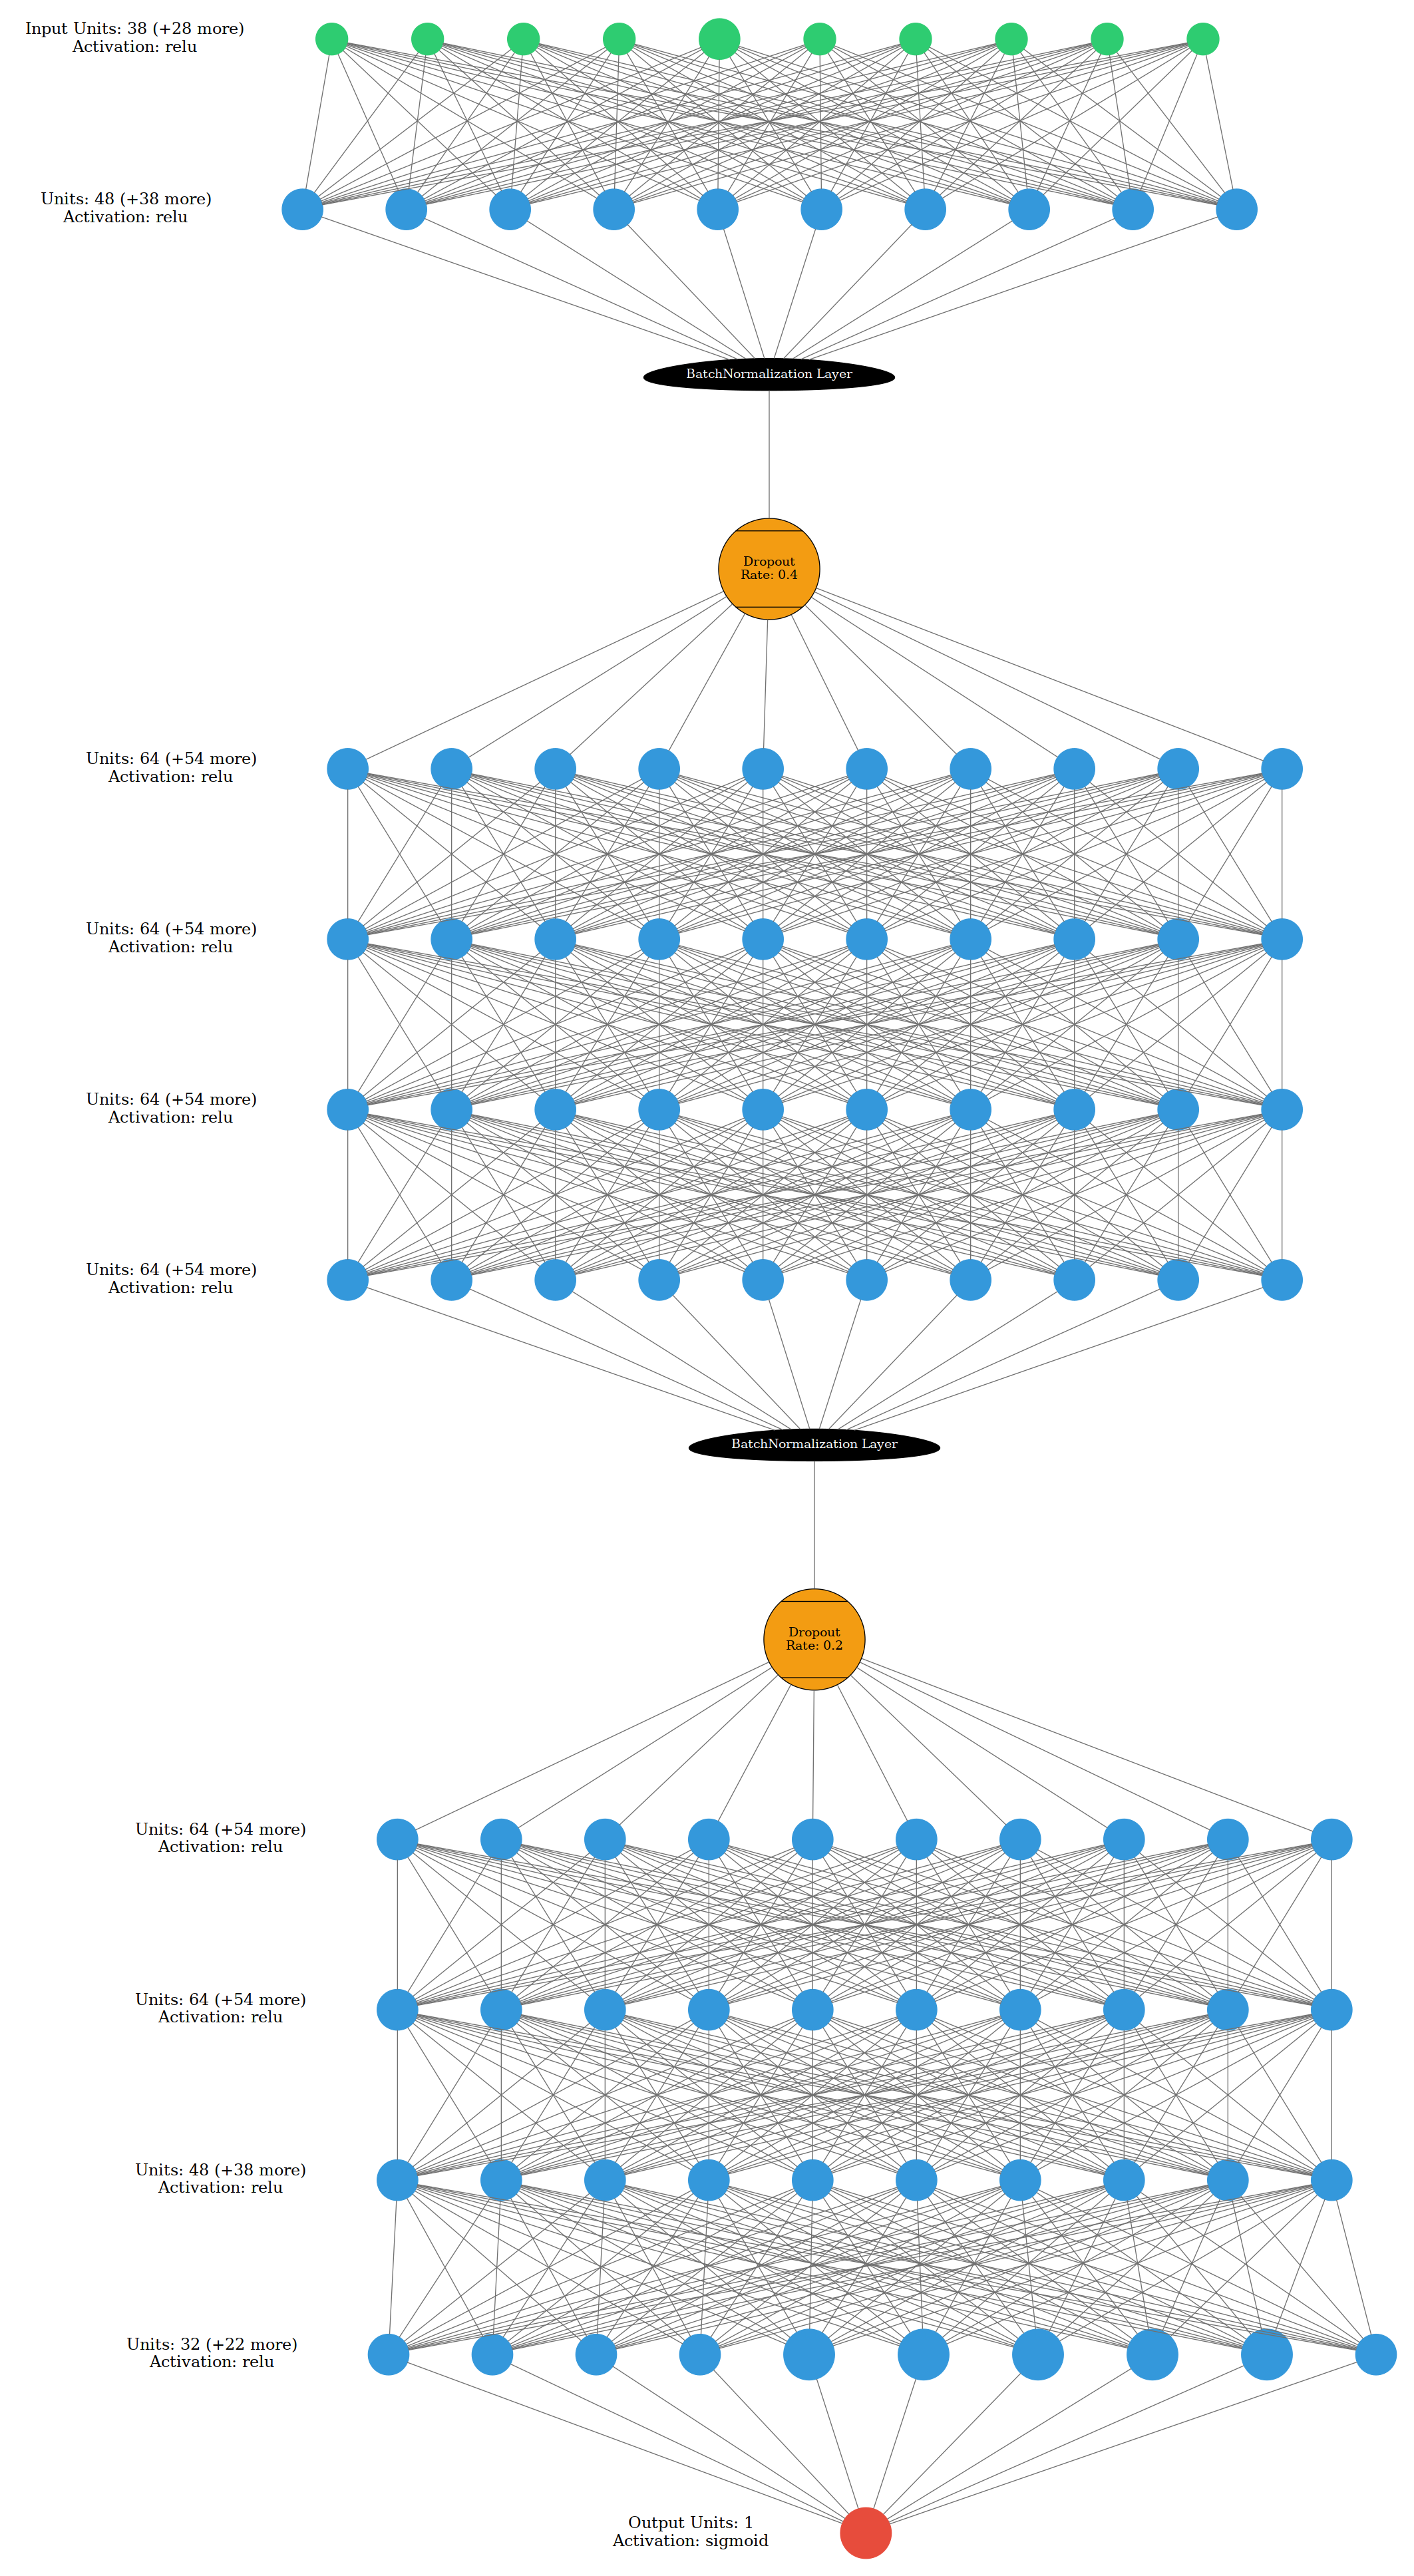

In [6]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [7]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights
class_weights = {0: 1.0, 1: 0.08} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=16,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/16


2024-11-23 19:18:53.971053: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-11-23 19:18:55.773491: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9f6c68e860 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-23 19:18:55.773511: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-11-23 19:18:55.778384: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-23 19:18:55.791698: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1732385935.858380 2134034 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 10s 6ms/step - loss: 5.1530 - precision: 0.7496 - recall: 0.3745 - auc: 0.7618 - val_loss: 5.1759 - val_precision: 0.9997 - val_recall: 0.3696 - val_auc: 0.9617
Epoch 2/16
938/938 [==============================] - 4s 5ms/step - loss: 4.5142 - precision: 0.9973 - recall: 0.2857 - auc: 0.9467 - val_loss: 4.6741 - val_precision: 0.9997 - val_recall: 0.5266 - val_auc: 0.9726
Epoch 3/16
938/938 [==============================] - 5s 5ms/step - loss: 4.0037 - precision: 0.9982 - recall: 0.5342 - auc: 0.9612 - val_loss: 4.1882 - val_precision: 0.9996 - val_recall: 0.7357 - val_auc: 0.9770
Epoch 4/16
938/938 [==============================] - 5s 5ms/step - loss: 3.5366 - precision: 0.9982 - recall: 0.7047 - auc: 0.9661 - val_loss: 3.7227 - val_precision: 0.9996 - val_recall: 0.7795 - val_auc: 0.9794
Epoch 5/16
938/938 [==============================] - 4s 5ms/step - loss: 3.1060 - precision: 0.9981 - recall: 0.7686 - auc: 0.9688 - val_loss: 3.2857 - v

# Save the model

In [8]:
model.save('models/decision_nn_model.keras')

# Display training results

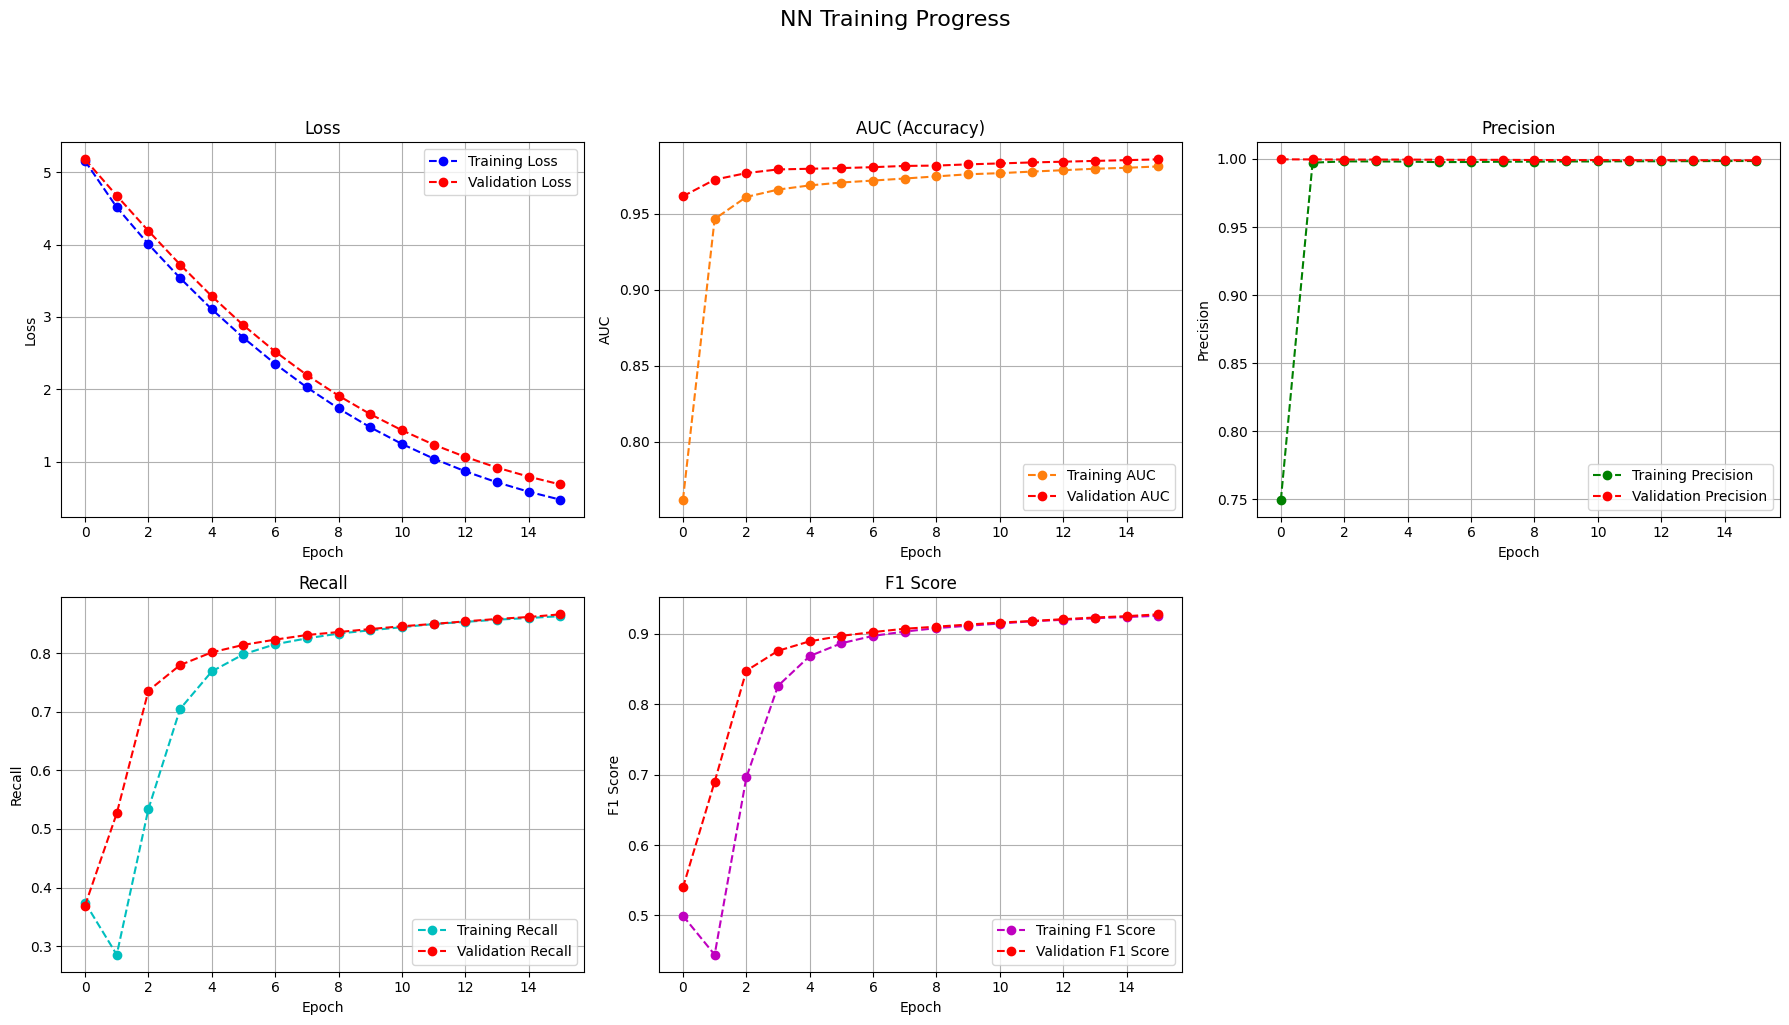

In [9]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score with epsilon to avoid division by zero
epsilon = 1e-10  # small value to prevent division by zero
epoch_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

3750/3750 [==============================] - 6s 2ms/step - loss: 0.6865 - precision: 0.9990 - recall: 0.8659 - auc: 0.9860
Loss =  0.6865161061286926
Accuracy =  0.999000072479248
3750/3750 [==============================] - 4s 1ms/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.8817    0.9991    0.9367     60000
   Malicious     0.9990    0.8659    0.9277     60000

    accuracy                         0.9325    120000
   macro avg     0.9403    0.9325    0.9322    120000
weighted avg     0.9403    0.9325    0.9322    120000

False Positive Rate = 0.0008666666666666666

Confusion Matrix:
[[59948    52]
 [ 8047 51953]]


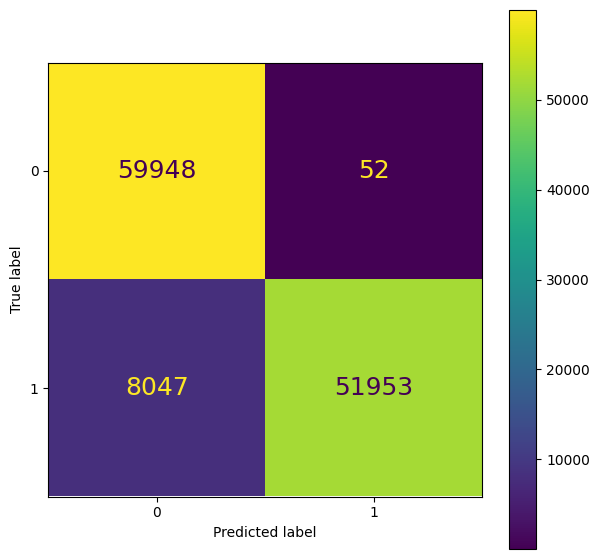

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

# Feature Importance Analysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 1001it [01:00, 14.36it/s]                                                                                                                                              
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


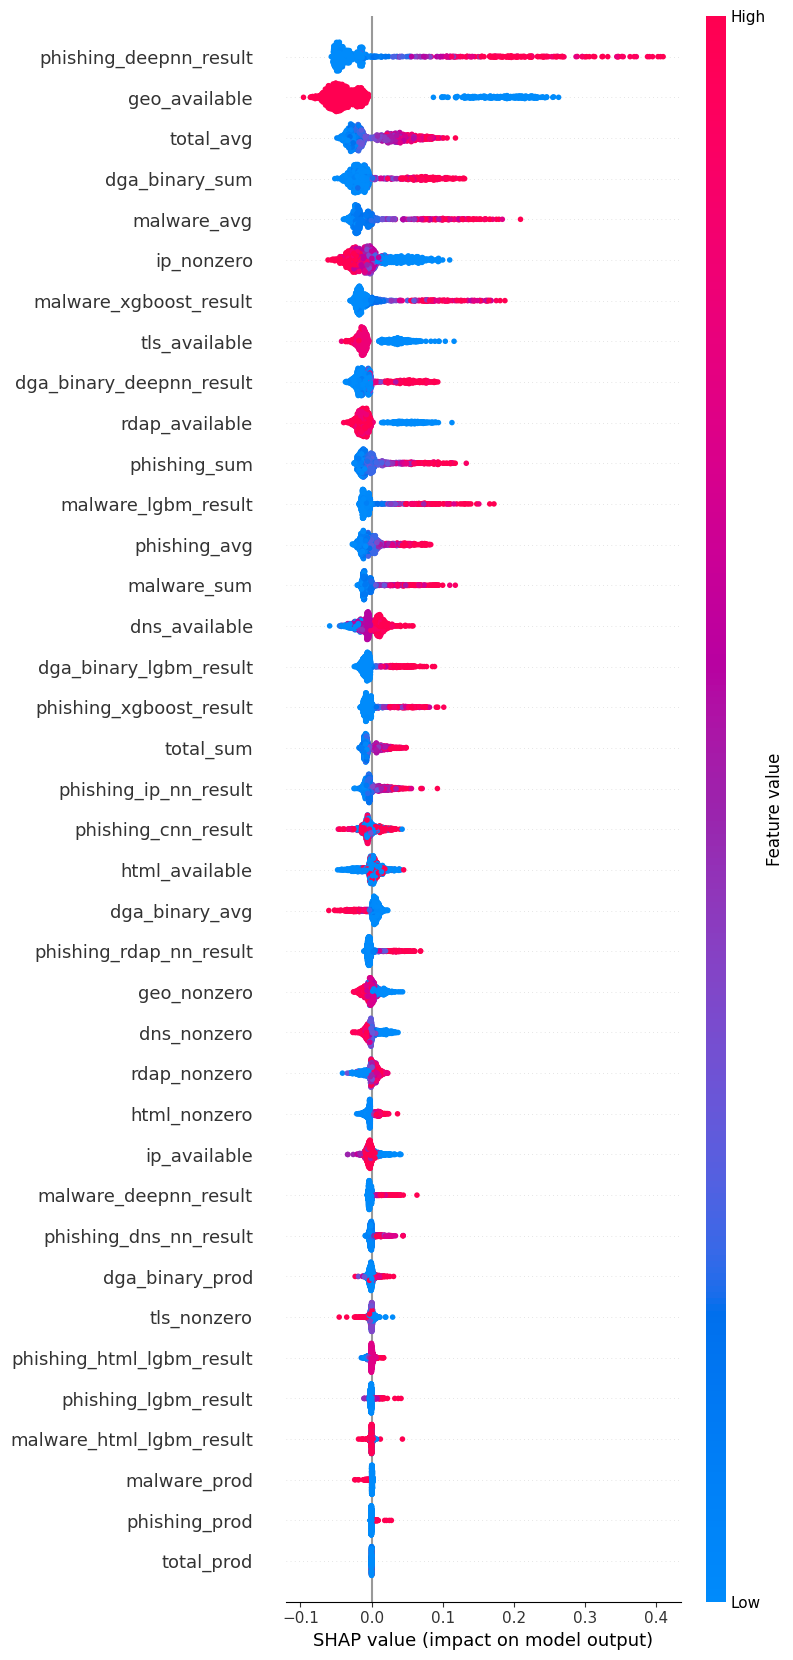

In [11]:
import shap

# Ensure that X_train and X_test are DataFrames with the correct column names
# You can set the column names from the 'features' DataFrame like this:
X_train.columns = features.columns
X_test.columns = features.columns

n_samples = 1000

# Convert your training set to a NumPy format if it's not already
background = X_train[:n_samples].to_numpy()

# Use the generic SHAP Explainer interface
explainer = shap.Explainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer(X_test[:n_samples].to_numpy())

# Plotting the summary plot for feature importance
# Use the column names from the 'features' DataFrame as the feature names
shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=39)
